In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import torch
import torchutil
import promonet

/home/mrm5248/micromamba/envs/promonet/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Get distribution without augmentation or variable-width
promonet.AUGMENT_PITCH = False
promonet.AUGMENT_LOUDNESS = False
allpitch = []
dataset = promonet.data.Dataset('vctk', 'train')
for stem in torchutil.iterator(
    dataset.stems,
    'promonet.load.pitch_distribution'
):
    pitch = torch.load(
        dataset.cache / f'{stem}-viterbi-pitch.pt')
    periodicity = torch.load(
        dataset.cache / f'{stem}-viterbi-periodicity.pt')
    allpitch.append(
        pitch[torch.logical_and(~torch.isnan(pitch), periodicity > promonet.VOICING_THRESHOLD)])
hz, _ = torch.sort(torch.cat(allpitch))
hz = torch.clip(hz, promonet.FMIN, promonet.FMAX)
logfmin = torch.log2(torch.tensor(promonet.FMIN))
logfmax = torch.log2(torch.tensor(promonet.FMAX))
centered = torch.log2(hz) - logfmin
normalized = centered / (logfmax - logfmin)
original_bins = ((promonet.PITCH_BINS - 1) * normalized).to(torch.long)
indices = torch.linspace(
    0.,
    len(hz) - 1,
    promonet.PITCH_BINS,
    dtype=torch.float64
).to(torch.long)
original_distribution = hz[indices]
original_distribution[0] = promonet.FMIN

promonet.load.pitch_distribution: 100%|██████████| 87894/87894 [01:00<00:00, 1451.69it/s]


In [18]:
# Get distribution with augmentation
promonet.AUGMENT_PITCH = True
promonet.AUGMENT_LOUDNESS = True
allpitch = []
dataset = promonet.data.Dataset('vctk', 'train')
for stem in torchutil.iterator(
    dataset.stems,
    'promonet.load.pitch_distribution'
):
    pitch = torch.load(
        dataset.cache / f'{stem}-viterbi-pitch.pt')
    periodicity = torch.load(
        dataset.cache / f'{stem}-viterbi-periodicity.pt')
    allpitch.append(
        pitch[torch.logical_and(~torch.isnan(pitch), periodicity > promonet.VOICING_THRESHOLD)])
hz, _ = torch.sort(torch.cat(allpitch))
hz = torch.clip(hz, promonet.FMIN, promonet.FMAX)
logfmin = torch.log2(torch.tensor(promonet.FMIN))
logfmax = torch.log2(torch.tensor(promonet.FMAX))
centered = torch.log2(hz) - logfmin
normalized = centered / (logfmax - logfmin)
augmented_bins = ((promonet.PITCH_BINS - 1) * normalized).to(torch.long)
indices = torch.linspace(
    len(hz) / promonet.PITCH_BINS,
    len(hz) - 1,
    promonet.PITCH_BINS,
    dtype=torch.float64
).to(torch.long)
augmented_distribution = hz[indices]

promonet.load.pitch_distribution: 100%|██████████| 263672/263672 [03:17<00:00, 1338.13it/s]


In [19]:
variable_bins = torch.clip(torch.searchsorted(hz[indices], hz), 0, promonet.PITCH_BINS - 1)

In [20]:
print(variable_bins)

tensor([  0,   0,   0,  ..., 255, 255, 255])


In [21]:
print(len(hz), indices)

25211924 tensor([   98484,   196968,   295452,   393936,   492420,   590904,   689388,
          787872,   886356,   984840,  1083324,  1181808,  1280292,  1378777,
         1477261,  1575745,  1674229,  1772713,  1871197,  1969681,  2068165,
         2166649,  2265133,  2363617,  2462101,  2560585,  2659070,  2757554,
         2856038,  2954522,  3053006,  3151490,  3249974,  3348458,  3446942,
         3545426,  3643910,  3742394,  3840878,  3939362,  4037847,  4136331,
         4234815,  4333299,  4431783,  4530267,  4628751,  4727235,  4825719,
         4924203,  5022687,  5121171,  5219655,  5318140,  5416624,  5515108,
         5613592,  5712076,  5810560,  5909044,  6007528,  6106012,  6204496,
         6302980,  6401464,  6499948,  6598432,  6696917,  6795401,  6893885,
         6992369,  7090853,  7189337,  7287821,  7386305,  7484789,  7583273,
         7681757,  7780241,  7878725,  7977210,  8075694,  8174178,  8272662,
         8371146,  8469630,  8568114,  8666598,  876508

In [23]:
original_counts = torch.bincount(original_bins, minlength=promonet.PITCH_BINS)
augmented_counts = torch.bincount(augmented_bins, minlength=promonet.PITCH_BINS)
variable_counts = torch.bincount(variable_bins, minlength=promonet.PITCH_BINS)
original_normalized = original_counts / sum(original_counts)
augmented_normalized = augmented_counts / sum(augmented_counts)
variable_normalized = variable_counts / sum(variable_counts)
ymax = max(variable_normalized.max(), augmented_normalized.max(), original_normalized.max())

In [25]:
variable_counts

tensor([98485, 98484, 98484, 98484, 98484, 98484, 98485, 98483, 98485, 98483,
        98484, 98486, 98482, 98485, 98485, 98483, 98485, 98483, 98486, 98482,
        98484, 98484, 98484, 98485, 98485, 98486, 98481, 98485, 98484, 98483,
        98484, 98484, 98488, 98481, 98483, 98484, 98484, 98486, 98487, 98480,
        98487, 98483, 98483, 98483, 98486, 98482, 98487, 98482, 98484, 98484,
        98485, 98483, 98486, 98483, 98483, 98486, 98483, 98484, 98484, 98484,
        98483, 98484, 98486, 98485, 98481, 98486, 98484, 98490, 98477, 98486,
        98486, 98480, 98490, 98478, 98485, 98488, 98485, 98478, 98488, 98481,
        98491, 98478, 98484, 98485, 98482, 98485, 98487, 98484, 98483, 98481,
        98486, 98483, 98483, 98488, 98483, 98482, 98488, 98480, 98486, 98482,
        98487, 98481, 98488, 98484, 98482, 98484, 98484, 98486, 98484, 98486,
        98481, 98482, 98490, 98479, 98483, 98485, 98483, 98484, 98486, 98484,
        98488, 98480, 98484, 98487, 98485, 98482, 98483, 98485, 

In [26]:
def entropy(d):
    return - (d * torch.log(d + 1e-9)).sum()
original_entropy = entropy(original_normalized)
augmented_entropy = entropy(augmented_normalized)
variable_entropy = entropy(variable_normalized)

In [27]:
xlabels = torch.tensor([50, 100, 200, 400])
original_xticks = ((promonet.PITCH_BINS - 1) * (torch.log2(xlabels) - promonet.LOG_FMIN) / (promonet.LOG_FMAX - promonet.LOG_FMIN)).to(torch.long)
augmented_xticks = original_xticks
variable_xticks = torch.clip(torch.searchsorted(hz[indices], xlabels), 0, promonet.PITCH_BINS - 1)
xlabels = xlabels.tolist()
variable_xlabels = xlabels.copy()
variable_xlabels[-1] = f'{xlabels[-1]} ' + r'$\bf{Hz}$'

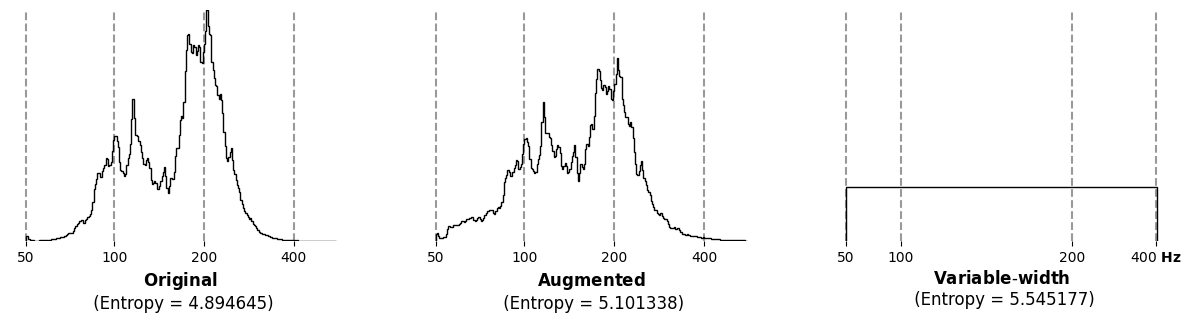

In [28]:
figure, axes = plt.subplots(1, 3, figsize=(15, 3))
axes[0].stairs(original_counts, color='black')
axes[0].set_xlabel(r'$\bf{Original}$' + f'\n (Entropy = {original_entropy:02f})', fontsize=12)
axes[0].set_xticks(original_xticks, xlabels)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].spines['bottom'].set_visible(False)
axes[0].spines['left'].set_visible(False)
axes[0].get_yaxis().set_ticks([])
axes[0].set_ylim(0., ymax * original_counts.sum())
for tick in original_xticks:
    axes[0].vlines(tick, 0, ymax * original_counts.sum(), color='black', linestyle='--', alpha=.4)
axes[1].stairs(augmented_counts, color='black')
# axes[1].set_title('Maximizing the entropy of the pitch training distribution', weight='bold', fontsize=14)
axes[1].set_xlabel(r'$\bf{Augmented}$' + f'\n (Entropy = {augmented_entropy:02f})', fontsize=12)
axes[1].set_xticks(augmented_xticks, xlabels)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].spines['bottom'].set_visible(False)
axes[1].spines['left'].set_visible(False)
axes[1].get_yaxis().set_ticks([])
axes[1].set_ylim(0., ymax * augmented_counts.sum())
for tick in augmented_xticks:
    axes[1].vlines(tick, 0, ymax * augmented_counts.sum(), color='black', linestyle='--', alpha=.4)
axes[2].set_xlabel(r'$\bf{Variable}$-$\bf{width}$' + f'\n (Entropy = {variable_entropy:02f})', fontsize=12)
axes[2].set_xticks(variable_xticks, variable_xlabels)
axes[2].stairs(variable_counts, color='black')
axes[2].spines['top'].set_visible(False)
axes[2].spines['right'].set_visible(False)
axes[2].spines['bottom'].set_visible(False)
axes[2].spines['left'].set_visible(False)
axes[2].get_yaxis().set_ticks([])
axes[2].set_ylim(0., ymax * variable_counts.sum())
for tick in variable_xticks:
    axes[2].vlines(tick, 0, ymax * variable_counts.sum(), color='black', linestyle='--', alpha=.4)
figure.savefig('pitch-entropy.pdf', bbox_inches='tight', pad_inches=0, dpi=300)